<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_05_CNN_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks Architectures
In this lab, we will learn about well-known CNN architectures in the field of computer vision and how to implement them in Keras. 






# CNNs in Image Classification
We will start this part by presenting the networks that have been widely used for image classification.  (One of the most famous problems among the computer vision community is the annual software contest run by the ImageNet project, **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)**. This task evaluates how well an algorithm does in the tasks of object category classification and detection on hundreds of object categories and millions of images. 

As ImageNet is a massive dataset, we will use instead CIFAR10 dataset, which is directly available on Keras. 

CIFAR10 dataset contains 10 different classes and 32x32 images, instead of 224x224 as in ImageNet. We will show how to resize the data to be able to use some of the following architectures, as not all of the CNN accepts arbitrary input sizes. The ones that do, will use the original CIFAR10 input size. 

In [1]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical # to one-hot the categories 

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

To resize the dataset, and as a CIFAR10 224x224 version would not fit in our RAM, we need to create a preprocessing step before the first layer. This step will resize the input batch to the required size. To do so, we use the `Lambda` layer in Keras, which wraps any expression (in this case `resize_images`) in a layer. We can see how this function looks like for a single batch of 32 images.

In [2]:
x_train.shape # it's a 50,000 patch or data each of size 32x32x3 (RGB images)

(50000, 32, 32, 3)

(50000, 32, 32, 3)

- we will resize using image-resize that does so using interpolation which is the worst way of resizing 

In [3]:
#tips lambda function 
# this is a way in python that let us define small functions in succent way 
# lets see this function
def add_5(x):
    return x + 5

fun = lambda x: x + 5

In [4]:
add_5(3)

8

8

In [5]:
fun(3)

8

8

- pytorch , tensorflow and keras all adopted this concept of lambda 
- that's how we will define our resizing function,mine: there is a lambda layer in keras that wraps our lambda in a layer (a layer that does what lambda function intends to do) 

In [6]:
x_train[:32, ...].shape # takes the first 32 image and the rest of the axes as they are 

(32, 32, 32, 3)

(32, 32, 32, 3)

1/1 [==============================] - 1s 672ms/step
(32, 224, 224, 3)
(32, 224, 224, 3)


C:\Users\youse\AppData\Local\Temp\ipykernel_7628\4154371738.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_resized = np.asarray(x_train_resized, dtype = np.int)
C:\Users\youse\AppData\Local\Temp\ipykernel_7628\4154371738.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current u

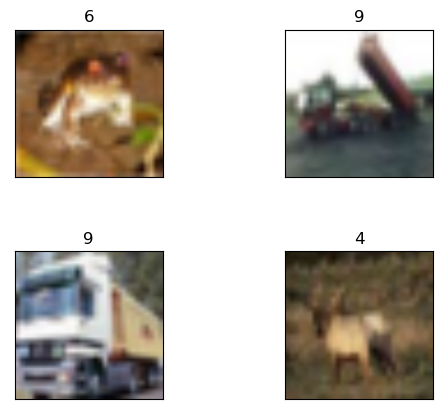

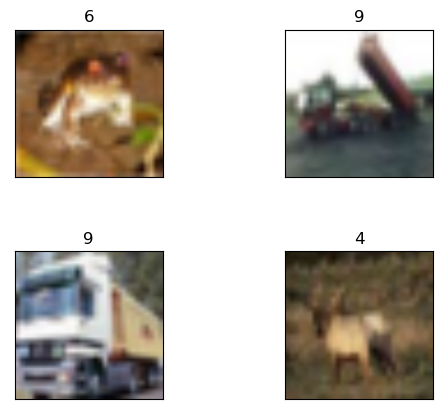

In [7]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as tf
#ktf.logging.set_verbosity(ktf.logging.ERROR)


inp = Input(shape=(32, 32, 3))
fun = Lambda(lambda image: tf.image.resize(image, (224, 224)))
out = fun(inp)

model = Model(inputs=inp, outputs=out)

x_train_resized = model.predict(x_train[:32, ...])
print(x_train_resized.shape)

# Visualization purposes
x_train_resized = np.asarray(x_train_resized, dtype = np.int)
    
# Let's visualize some examples
N=2
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = list(range(0, 100))
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(x_train_resized[idx], cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    y_target = int(y_train[idx])
    target = str(items[y_target])
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [8]:
y_train.min(),y_train.max() # 10 labels from 0 to 9 

(0, 9)

(0, 9)

Let's get ready the dataset: (preprocessing)

In [9]:
x_train.dtype

dtype('uint8')

dtype('uint8')

In [10]:
# one-hot the labels 
num_classes = 10
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

# normalize the x train by dividng by max
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

print('Original training data shape: {}'.format(x_train.shape))
print('Training label shape: {}'.format(y_train.shape))

Original training data shape: (50000, 32, 32, 3)
Training label shape: (50000, 10)
Original training data shape: (50000, 32, 32, 3)
Training label shape: (50000, 10)


In [11]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## AlexNet

AlexNet made a huge impact in 2012 when it reduced the top-5 error (i.e. the correct class is not among the top-5 predictions) from 26% to 15.3% in the ImageNet challenge. The second place was close to 26.2%, and it was not a CNN based system. AlexNet shares a lot with its predecessor architecture, [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) by Yann LeCun et al. However, in this case, the computational complexity was more plausible to deal with that it was years before, therefore, authors decided to make the architecture bigger: more convolutional layers and more filters. 

The architecture designed in their paper:

![texto alternativo](https://i.ibb.co/QFG561f/0-x-POQ3bt-Z9r-QO23-LK.png)

The network consisted of convolutional layers with kernels of 11x11, 5x5 and 3x3. The architecture uses layers with strides, max poolings, dropouts, ReLU activation functions, and three dense layers at the end. The original network was split in two, as seen in the figure above, however, due to GPU constraints authors needed to train it on two separate GPUs. We found a great implementation in [Rizwan's blog](https://engmrk.com/alexnet-implementation-using-keras/), where it presented an AlexNet model without the split concept.

In [12]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

model = Sequential()

# Resize input image
model.add(Lambda(lambda x: tf.image.resize(x, (224, 224)), input_shape=(32,32,3)))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding="valid"))

# 4th Convolutional Layer


# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

# Passing it to a Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096))
model.add(Activation("relu"))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))


# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation("relu"))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(10))
model.add(Activation('softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                    

Now, we are ready to train this AlexNet model on CIFAR10. 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

model.fit(x_train, y_train, batch_size=1024, validation_split=0.2, epochs=3)

Epoch 1/3
Epoch 1/3


Let's test it:

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Training this kind of architectures in big datasets is time-consuming. We might need to train for several hours to start getting good results. That is why Keras offers several pre-trained models on the ImageNet dataset. Those models can be used directly for image prediction, image classification, feature extraction, or fine-tuning, among others, without the need of spending long hours of training. Even if the task or the dataset is different, using the pre-trained weights as initialization for the training process provides usually quite better results (as well as less time needed for training and better accuracy) than using a random initialization.

# Loading Pre-trained Models in Keras

As mentioned, Keras contains many models that have been pre-trained in the ImageNet dataset to solve the ILSVRC competition. Those deep learning models are made available alongside their pre-trained weights, which has become a common practice to initialize networks. You can learn more about it [here](https://keras.io/applications/). 

We will show how to instantiate the models and load their weights. Afterward, we will modify the last layer to classify only the 10 classes belonging to CIFAR10.

## VGGNet

VGGNet is an architecture presented by Simonyan and Zisserman in 2014. VGGNet is similar to previous AlexNet, however, it only contains 3x3 convolutional kernels and many more filters. It is widely used for extracting features, not only for image classification but for many other computer vision domains, such as feature representation, style transfer or the image description. You can check the [paper](https://arxiv.org/pdf/1409.1556.pdf) for further details. Next image shows VGG16 architecture ([source](https://www.cs.toronto.edu/~frossard/post/vgg16/)):

![](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

The training time of the architecture is massive since it has more than 130 million parameters. Thankfully, we can find it already pre-trained in Keras. Keras has the two proposed versions, VGG16 and VGG19, where the difference lies in the number of weight layers within the network.


In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16(input_shape=(224, 224, 3))

# Optionally, uncomment the following line to display the full model
model.summary()

If we want to load weights from ImageNet we only need to initialize the model as follows:

In [ ]:
model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

Now, we want to change the last layer for one dense layer with 10 activation neurons. This new layer will allow us to perform classification on CIFAR10. Besides, we will freeze all pre-trained layers and only allow the new dense layer to be trained. 

In [ ]:
from keras.models import Model
from keras.layers import Dense

#Load the VGG
model = VGG16(weights="imagenet", input_shape=(224, 224, 3), include_top=True)

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False
    
output = model.get_layer("fc2").output
output = Dense(units=10, activation="softmax")(output)
model = Model(inputs=model.input, outputs=output)


Let's see the model now, and confirm that the last layer is not there anymore, and instead, we have a new dense layer with only 10 activations. Also, as we have frozen the weights of the model, we should see only the trainable parameters belonging to the new dense layer.

In [ ]:
model.summary()

 As we have done before, we can add the lambda function to resize the images within our Keras model:

In [ ]:
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: tf.image.resize(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

If we want to use images of 32x32 we need to set the argument `include_top` to `False`, which will remove all dense layers at the end of the architecture. The dense layers in VGG are the ones that limit the input size to be 224x224 as they need a fixed dimension as input. Also, note that due to the MaxPooling operations, we need inputs of at least 32x32. If we remove the dense layers, we need to include new ones before starting the training process.



In [ ]:
from keras.layers import Dense, Flatten

model = VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer as in VGG16
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

In [ ]:
model.summary()

Now we have trainable parameters belonging to the last layers, so we are ready to fine-tune the VGG architecture.

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=1024,  validation_split=0.2)

Let's evaluate it:

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## GoogLeNet / Inception v1

Google presented [GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) in 2014, the same year that VGGNet was introduced.  GoogLeNet won the ImageNet competition achieving a top-5 error rate of 6.67%, almost betting the human error rate (5%). 

GoogLeNet introduced many ideas that helped the development of current state-of-the-art architectures. Instead of stacking more and more CNN layers, GoogLeNet introduced what the called inception modules:
 
![](https://i.ibb.co/JKqptrj/Googlenet-inception.png)

Those modules apply convolutions with 3 different sizes of kernels (1x1, 3x3 and 5x5) at the same level. The idea behind those modules is based on the premise that significant information can be presented in images at numerous different sizes. Therefore, by using a multi-scale approach, they are more likely to capture meaningful information. Moreover, they claimed that by designing a wider, instead of deeper, architecture helps the gradients to go through the entire network easily.

![](https://cdn-images-1.medium.com/max/1600/1*uW81y16b-ptBDV8SIT1beQ.png)

The architecture consisted of 9 inception modules stacked linearly, containing 22 deep CNN layers, however, the total number of parameters was reduced to 4 millions! Authors also included two auxiliary classifiers in the middle part of the architecture to avoid the vanishing gradient problem.

You can find a Keras implementation [here](https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14).

Original Inception v1 was a complex and heavily engineered architecture, and therefore many tricks were presented to push its performance, both in terms of speed and accuracy. The constant evolution of the architecture leads to the creation of several versions, a list and explanation of their differences can be found in [this blog](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).  

In Keras, the Inception v3 architecture is available, together with its pre-trained weights on ImageNet. It can be initialized as follows:

In [ ]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=True, weights='imagenet', classes=1000)

We can see its performance in CIFAR10. First of all, we will resize images to 75x75  which is the minimum size required by Inception v3 to work:

In [ ]:
from keras.models import Model
from keras.layers import Lambda, Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

# Resize Input images to 75x75

# Freeze all the layers

# Add Dense layer to classify on CIFAR10

model.summary()

We can train Inception v3:

In [ ]:
print(x_train.shape)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2)

And check its accuracy:

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## ResNet

In 2015 the winner of the ImageNet challenge was the Residual Neural Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf)) architecture. Similar to Inception, ResNet is built by micro-architectures modules, called residual blocks. Those blocks introduced skip connections, which allowed to train huge architectures (152 layers) while still having lower complexity than VGGNet. Those residual connections also allowed them to create deeper architectures since the gradient could backpropagate easier through the skip connections. Next image is from [Das' blog](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) and shows ResNet architecture with its skip connections:

![texto alternativo](https://cdn-images-1.medium.com/max/800/0*pkrso8DZa0m6IAcJ.png)

Keras offers the implementation of ResNet50 pre-trained on ImageNet. In addition to ResNet50, deeper versions of it, ResNet101 or ResNet152, are widely used nowadays. The main difference lies in the number of layers, e.g., ResNet50 is a 50 layer Residual Network.

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.resnet import ResNet50

model = ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers


# Add Dense layer to classify on CIFAR10
output = ###

Let's check the performance:

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2)

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Xception, DenseNet, InceptionResNet ...

Keras offers many more network implementations trained on ImageNet. You can check the [documentation](https://keras.io/applications/) to see all of them. Besides, the documentation reports their accuracies, number of parameters and depth of each architecture. 

# CNN on Others Domains

Besides the success of CNNs in classification problems, CNNs have been used in many other domains, such as object detection, facial recognition, image segmentation, image captioning, image generation, among others. We present now two state-of-the-art architectures.


## Denoising with UNet

[UNet](https://arxiv.org/pdf/1505.04597.pdf) was presented in 2015 for biomedical image segmentation, but since then, it has been employed in many different tasks such as as semantic segmentation, generative models, denoising... The idea is similar to an encoder-decoder layout. The first part of the network encodes the image and reduces it to a map of smaller size, forcing it to capture the important information. Then, the next part is in charge of decoding the image from that vector.

UNet presents also skip connections between the encoder and the decoder to allow easier flow of information.


Now let's define the UNet architecture.


In [ ]:
from keras.layers import Input, UpSampling2D, concatenate 
from keras.models import Model

inputs = Input((32, 32, 3))

# define encoder
conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation="relu", padding="same")(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation="relu", padding="same")(pool4)
#pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

## Now the decoder starts
up6 = Conv2D(512, 3, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv5))
merge6 = concatenate([conv4, up6], axis=3)
conv6 = Conv2D(512, 3, activation="relu", padding="same")(merge6)

up7 = Conv2D(256, 3, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(256, 3, activation="relu", padding="same")(merge7)

up8 = Conv2D(128, 3, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation="relu", padding="same")(merge8)

up9 = Conv2D(64, 3, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation="relu", padding="same")(merge9)

conv10 = Conv2D(3, 3, padding="same")(conv9)

model = Model(inputs = inputs, outputs = conv10)

We have CIFAR10 images loaded from previous experiments. We are going to add some Gaussian noise (you can play with the scale of the noise) and then train the UNet to remove the noise from the images. To do so, we train with the noisy image as input and the clean image as the target. We use the Mean Absolute Error as the loss function to optimize the architecture.

In [ ]:
import numpy as np

x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(x_train_noise, x_train, batch_size=1024, epochs=3, validation_split=0.2)

In [ ]:
pred = model.predict(x_test_noise)

We now visualize the noisy image next to the output of the UNet. The output images are a little bit blurred, but the noise has been reduced.

In [ ]:
import matplotlib.pyplot as plt

N=2
start_val = 2# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_test_noise[idx], 0, 1), np.clip(pred[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])
